# Estratégias para Previsão de Múltiplos Horizontes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from preprocessing import make_shifts
from metrics import all_metrics_from_dataframes

## 1. Pré-processamento

In [2]:
df = pd.read_csv('../data/australia_wind_power.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.rolling(6).mean()
df = df.iloc[6::6]

In [3]:
# df.isna().sum().sort_values()

In [4]:
df = df[['BOCORWF1', 'MACARTH1','STARHLWF']]    # 0, 0, 34 NaN
df = df.interpolate(method='polynomial', order=5, axis=0)
df = df.clip(lower=0)

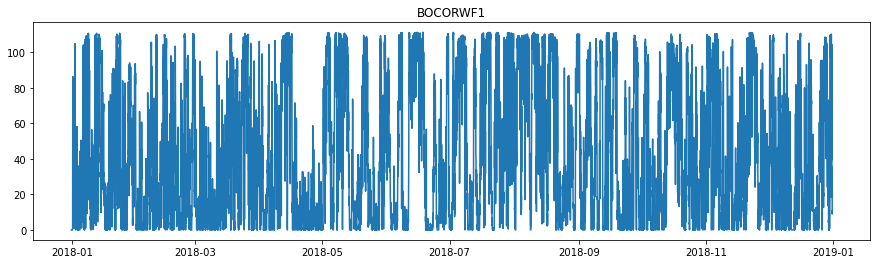

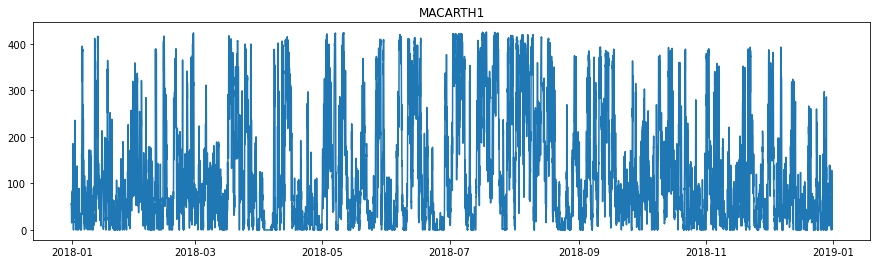

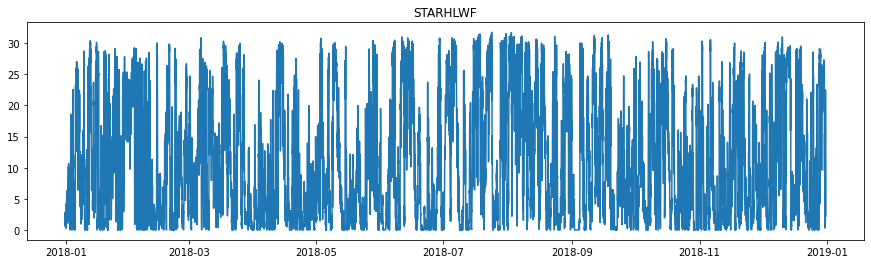

In [5]:
for label, serie in df.items():
    plt.figure(figsize=(15,4))
    plt.title(label)
    plt.plot(serie)
    plt.savefig(f'../images/{label}.png')

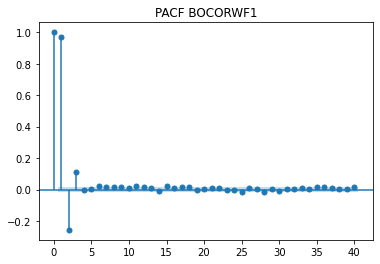

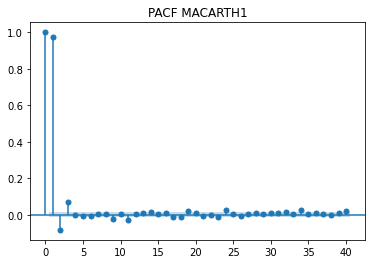

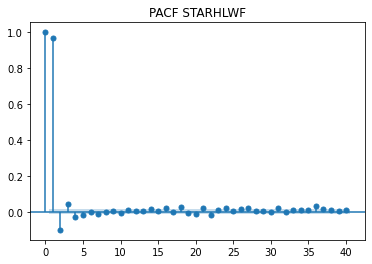

In [6]:
for label, serie in df.items():
    plot_pacf(serie, title=f'PACF {label}', lags=40)
    plt.savefig(f'../images/PACF_{label}.png')

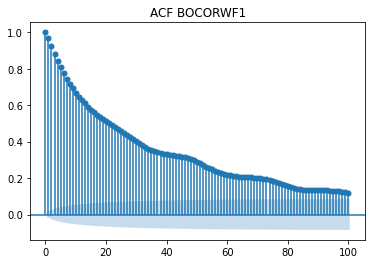

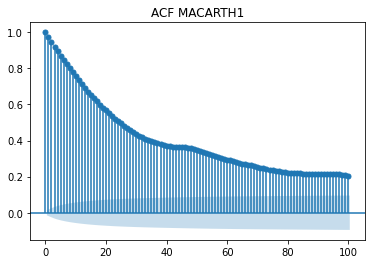

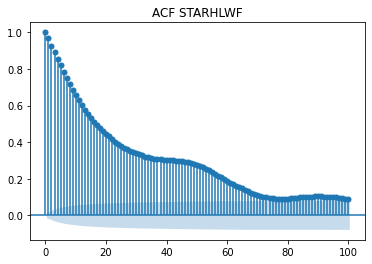

In [7]:
for label, serie in df.items():
    plot_acf(serie, title=f'ACF {label}', lags=100)
    plt.savefig(f'../images/ACF_{label}.png')

In [8]:
from sklearn.model_selection import train_test_split

LAGS = 5
HORIZONS = 3

MACARTH1 = make_shifts(df['MACARTH1'], lags=LAGS, horizons=HORIZONS)
X = MACARTH1.iloc[:,:LAGS]
y = MACARTH1.iloc[:,-HORIZONS:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False) 

In [9]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = MinMaxScaler().fit(y_train)
y_train = y_scaler.transform(y_train)

# 2. Estratégias
## 2.1 Direta

In [10]:
from direct import Direct

D_MLP = Direct('MLP', n_horizons=HORIZONS, n_inits=1)
D_MLP.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
D_MLP.train(X_train, y_train, validation_split=0.2, epochs=200)
predD_MLP = D_MLP.predict(X_test, y_scaler)
all_metrics_from_dataframes(predD_MLP, y_test)

Epoch 1/200
294/294 [==============================] - 0s 2ms/step - loss: 0.1596 - val_loss: 0.1221
Epoch 2/200
294/294 [==============================] - 0s 980us/step - loss: 0.0590 - val_loss: 0.0792
Epoch 3/200
294/294 [==============================] - 0s 884us/step - loss: 0.0349 - val_loss: 0.0422
Epoch 4/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 0.0210
Epoch 5/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 6/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 7/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 8/200
294/294 [==============================] - 0s 915us/step - loss: 0.0078 - val_loss: 0.0095
Epoch 9/200
294/294 [==============================] - 0s 863us/step - loss: 0.0069 - val_loss: 0.0084
Epoch 10/200
294/294 [==============================] - 0s 871us/step - loss: 0.006

,t+1,t+2,t+3
mse,838.238417,1741.756237,2457.012163
rmse,28.952347,41.734353,49.568258
bias,1.371653,2.225292,4.842886
mae,18.147225,27.495851,34.099252
mape,0.333404,0.482053,0.497122
corr_coef,0.960109,0.915284,0.879146
std_ratio,0.996597,0.968811,0.944134
rmsd,28.919837,41.674984,49.331112
ss4,0.053108,0.043820,0.037213


In [11]:
D_LSTM = Direct('LSTM', n_horizons=HORIZONS, n_inits=1)
D_LSTM.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
D_LSTM.train(X_train, y_train, validation_split=0.2, epochs=200)
predD_LSTM = D_LSTM.predict(X_test, y_scaler)
all_metrics_from_dataframes(predD_LSTM, y_test)

Epoch 1/200
294/294 [==============================] - 2s 6ms/step - loss: 0.1214 - val_loss: 0.1434
Epoch 2/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0754 - val_loss: 0.1149
Epoch 3/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0523 - val_loss: 0.0492
Epoch 4/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 5/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 6/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 7/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 8/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 9/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 10/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0062 - val_lo

,t+1,t+2,t+3
mse,834.596539,1749.077367,2468.725748
rmse,28.889385,41.821972,49.686273
bias,2.260610,6.157397,7.997362
mae,18.524963,28.831498,34.853159
mape,0.321531,0.413727,0.466238
corr_coef,0.959932,0.915483,0.879890
std_ratio,0.978311,0.943626,0.932756
rmsd,28.800802,41.366216,49.038433
ss4,0.053044,0.043754,0.037281


### 2.2 Múltiplas saídas

In [12]:
from multiout import Multiout

M_MLP = Multiout('MLP', n_horizons=HORIZONS, n_inits=1)
M_MLP.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
M_MLP.train(X_train, y_train, validation_split=0.2, epochs=200)
predM_MLP = M_MLP.predict(X_test, y_scaler)
all_metrics_from_dataframes(predM_MLP, y_test)

Epoch 1/200
294/294 [==============================] - 0s 1ms/step - loss: 0.3548 - val_loss: 0.2511
Epoch 2/200
294/294 [==============================] - 0s 900us/step - loss: 0.0965 - val_loss: 0.1616
Epoch 3/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0812 - val_loss: 0.1434
Epoch 4/200
294/294 [==============================] - 0s 862us/step - loss: 0.0781 - val_loss: 0.1367
Epoch 5/200
294/294 [==============================] - 0s 872us/step - loss: 0.0738 - val_loss: 0.1254
Epoch 6/200
294/294 [==============================] - 0s 923us/step - loss: 0.0646 - val_loss: 0.1033
Epoch 7/200
294/294 [==============================] - 0s 909us/step - loss: 0.0477 - val_loss: 0.0671
Epoch 8/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0369
Epoch 9/200
294/294 [==============================] - 0s 889us/step - loss: 0.0188 - val_loss: 0.0234
Epoch 10/200
294/294 [==============================] - 0s 916us/step - loss: 0

,t+1,t+2,t+3
mse,843.069470,1744.979320,2446.045678
rmse,29.035659,41.772950,49.457514
bias,0.526710,4.715397,5.361903
mae,18.225315,27.967826,34.184904
mape,0.331773,0.424337,0.476622
corr_coef,0.959842,0.915793,0.879371
std_ratio,0.997671,0.965389,0.934800
rmsd,29.030881,41.505955,49.166001
ss4,0.053049,0.043907,0.037204


In [13]:
M_LSTM = Multiout('LSTM', n_horizons=HORIZONS, n_inits=1)
M_LSTM.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
M_LSTM.train(X_train, y_train, validation_split=0.2, epochs=200)
predM_LSTM = M_LSTM.predict(X_test, y_scaler)
all_metrics_from_dataframes(predM_LSTM, y_test)

Epoch 1/200
294/294 [==============================] - 1s 5ms/step - loss: 0.1078 - val_loss: 0.1422
Epoch 2/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0786 - val_loss: 0.1281
Epoch 3/200
294/294 [==============================] - 1s 3ms/step - loss: 0.0582 - val_loss: 0.0597
Epoch 4/200
294/294 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0214
Epoch 5/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0145 - val_loss: 0.0167
Epoch 6/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 7/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0131
Epoch 8/200
294/294 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0129
Epoch 9/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0104 - val_loss: 0.0118
Epoch 10/200
294/294 [==============================] - 1s 4ms/step - loss: 0.0099 - val_lo

,t+1,t+2,t+3
mse,873.627637,1747.323709,2436.757622
rmse,29.557193,41.801001,49.363525
bias,5.834724,5.047504,5.600948
mae,19.518810,28.223520,34.388607
mape,0.317323,0.419944,0.474508
corr_coef,0.959599,0.915436,0.879439
std_ratio,0.985281,0.956914,0.924844
rmsd,28.975570,41.495137,49.044745
ss4,0.052984,0.043808,0.037158


### 2.3 Recursiva

In [14]:
from recursive import Recursive

R_MLP = Recursive('MLP', n_horizons=HORIZONS, n_inits=1)
R_MLP.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
R_MLP.train(X_train, y_train, validation_split=0.2, epochs=200)
predR_MLP = R_MLP.predict(X_test, y_scaler)
all_metrics_from_dataframes(predR_MLP, y_test)

Epoch 1/200
294/294 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0460
Epoch 2/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0150 - val_loss: 0.0136
Epoch 3/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0113
Epoch 4/200
294/294 [==============================] - 0s 994us/step - loss: 0.0087 - val_loss: 0.0099
Epoch 5/200
294/294 [==============================] - 0s 875us/step - loss: 0.0075 - val_loss: 0.0088
Epoch 6/200
294/294 [==============================] - 0s 868us/step - loss: 0.0065 - val_loss: 0.0077
Epoch 7/200
294/294 [==============================] - 0s 994us/step - loss: 0.0056 - val_loss: 0.0068
Epoch 8/200
294/294 [==============================] - 0s 950us/step - loss: 0.0050 - val_loss: 0.0065
Epoch 9/200
294/294 [==============================] - 0s 868us/step - loss: 0.0046 - val_loss: 0.0061
Epoch 10/200
294/294 [==============================] - 0s 824us/step - loss: 0

,t+1,t+2,t+3
mse,835.481569,1748.573693,2490.055619
rmse,28.904698,41.815950,49.900457
bias,2.233259,4.370872,6.563442
mae,18.373294,27.841650,34.380050
mape,0.326729,0.429821,0.479193
corr_coef,0.959973,0.915551,0.878928
std_ratio,0.982624,0.967081,0.950458
rmsd,28.818295,41.586887,49.466927
ss4,0.053062,0.043865,0.037203


In [15]:
R_LSTM = Recursive('MLP', n_horizons=HORIZONS, n_inits=1)
R_LSTM.build(hidden_layers=[10,5], input_size=LAGS, activation='sigmoid', optimizer='adam', loss='mse')
R_LSTM.train(X_train, y_train, validation_split=0.2, epochs=200)
predR_LSTM = R_LSTM.predict(X_test, y_scaler)
all_metrics_from_dataframes(predR_LSTM, y_test)

Epoch 1/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0546
Epoch 2/200
294/294 [==============================] - 0s 830us/step - loss: 0.0164 - val_loss: 0.0130
Epoch 3/200
294/294 [==============================] - 0s 818us/step - loss: 0.0095 - val_loss: 0.0108
Epoch 4/200
294/294 [==============================] - 0s 797us/step - loss: 0.0084 - val_loss: 0.0095
Epoch 5/200
294/294 [==============================] - 0s 848us/step - loss: 0.0073 - val_loss: 0.0083
Epoch 6/200
294/294 [==============================] - 0s 862us/step - loss: 0.0064 - val_loss: 0.0075
Epoch 7/200
294/294 [==============================] - 0s 807us/step - loss: 0.0056 - val_loss: 0.0067
Epoch 8/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 9/200
294/294 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 10/200
294/294 [==============================] - 0s 821us/step - loss: 0

,t+1,t+2,t+3
mse,843.307577,1781.580549,2557.666821
rmse,29.039759,42.208773,50.573381
bias,0.999837,1.827243,2.572433
mae,18.302359,27.559062,33.765487
mape,0.334815,0.455286,0.521789
corr_coef,0.959717,0.914718,0.877405
std_ratio,0.993532,0.990671,0.988460
rmsd,29.022541,42.169204,50.507914
ss4,0.053019,0.043751,0.037036


### 2.4 Híbrida

In [16]:
from hybrid import Hybrid

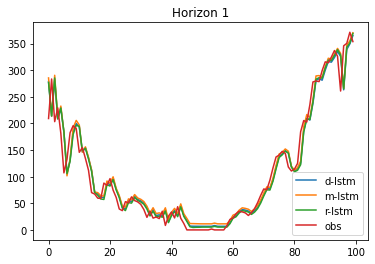

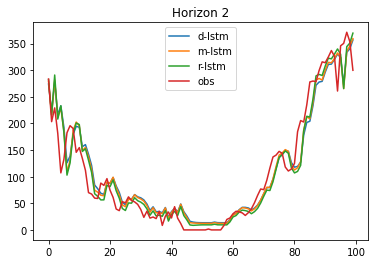

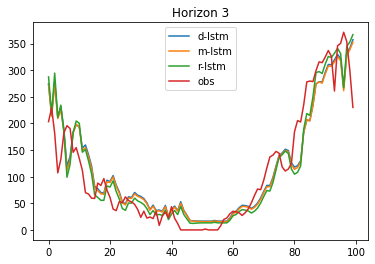

In [22]:
a = slice(200,300)
for h in range(1,HORIZONS+1):
  #  plt.plot(predD_MLP[f't+{h}'].values[a], label='d-mlp')
    plt.plot(predD_LSTM[f't+{h}'].values[a], label='d-lstm')
  #  plt.plot(predM_MLP[f't+{h}'].values[a], label='m-mlp')
    plt.plot(predM_LSTM[f't+{h}'].values[a], label='m-lstm')
  #  plt.plot(predR_MLP[f't+{h}'].values[a], label='r-mlp')
    plt.plot(predR_LSTM[f't+{h}'].values[a], label='r-lstm')
    plt.plot(y_test[f't+{h}'].values[a], label='obs')
    plt.legend()
    plt.title(f'Horizon {h}')
    plt.show()

In [18]:
MACARTH1

,t-4,t-3,t-2,t-1,t-0,t+1,t+2,t+3
timestamp,,,,,,,,
2018-01-01 02:30:00+10:00,54.710000,57.356667,46.665000,49.763333,52.016667,30.273333,23.081667,15.158333
2018-01-01 03:00:00+10:00,57.356667,46.665000,49.763333,52.016667,30.273333,23.081667,15.158333,26.096667
2018-01-01 03:30:00+10:00,46.665000,49.763333,52.016667,30.273333,23.081667,15.158333,26.096667,31.391667
2018-01-01 04:00:00+10:00,49.763333,52.016667,30.273333,23.081667,15.158333,26.096667,31.391667,26.401667
2018-01-01 04:30:00+10:00,52.016667,30.273333,23.081667,15.158333,26.096667,31.391667,26.401667,25.241667
...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00+10:00,102.666667,103.688333,92.920000,68.368333,52.600000,40.098333,32.400000,23.146667
2018-12-31 20:30:00+10:00,103.688333,92.920000,68.368333,52.600000,40.098333,32.400000,23.146667,14.986667
2018-12-31 21:00:00+10:00,92.920000,68.368333,52.600000,40.098333,32.400000,23.146667,14.986667,9.510000
